In [1]:
import logging
import sys

import numpy as np
import xgboost as xgb

sys.path.insert(0, "../")

logger = logging.getLogger()
logger.setLevel(logging.INFO)


In [2]:
from data_iq.dataiq_class import *
from src.utils.data_loader import *


# Load dataset

In [3]:
dataset = "support"
(
    train_loader,
    train_data,
    X_train,
    y_train,
    X_test,
    y_test,
    X_train_pd,
    y_train_pd,
    X_test_pd,
    y_test_pd,
    nlabels,
    corr_vals,
    column_ids,
    df,
) = load_dataset(dataset)


# Add features or samples and analyze Data-IQ

In [4]:
assess_feature_acquistion = (
    True  # set to False to assess adding samples rather than features
)

dataiq_list = []
models = []

nest = 50

if assess_feature_acquistion:
    # for added features experiment (feature acquisition)
    features = True
    samples = False

else:
    # for extra/added samples experiment
    features = False
    samples = True


if features:
    for n in range(1, len(column_ids) + 1):
        clf = xgb.XGBClassifier(n_estimators=nest)
        clf.fit(X_train[:, column_ids[0:n]], y_train)

        dataiq = DataIQ_SKLearn(X=X_train[:, column_ids[0:n]], y=y_train)

        for i in range(1, nest):
            dataiq.on_epoch_end(clf=clf, iteration=i)

        dataiq_list.append(deepcopy(dataiq))
        models.append(deepcopy(clf))

if samples:
    for n in range(1, 11, 1):

        samp_size = int((n / 10) * X_train.shape[0])

        ids = sample(range(X_train.shape[0]), samp_size)

        clf = xgb.XGBClassifier(n_estimators=nest)
        clf.fit(X_train[ids, :], y_train[ids])

        dataiq = DataIQ_SKLearn(X=X_train[ids, :], y=y_train[ids])

        for i in range(1, nest):
            dataiq.on_epoch_end(clf=clf, iteration=i)

        dataiq_list.append(deepcopy(dataiq))
        models.append(deepcopy(clf))


# Compute metrics

In [5]:
easy_uncert = []
ambig_uncert = []
hard_uncert = []

n_easy = []
n_ambig = []
n_hard = []


dataiq = True  # set to false to assess datamaps

for i in range(len(dataiq_list)):
    d_idx = i

    uncert_train = dataiq_list[d_idx].aleatoric
    confidence_train = dataiq_list[d_idx].confidence

    percentile_thresh = 50
    thresh = 0.25

    if not assess_feature_acquistion:
        thresh = 0.15

    conf_thresh_low = thresh
    conf_thresh_high = 1 - thresh
    conf_thresh = 0.5

    model_name = "dataiq"
    if not dataiq:
        uncert_train = dataiq_list[d_idx].variability
        model_name = "dc"
    n = i + 1

    hard_train = np.where(
        (confidence_train <= conf_thresh_low)
        & (uncert_train <= np.percentile(uncert_train, percentile_thresh))
    )[0]
    easy_train = np.where(
        (confidence_train >= conf_thresh_high)
        & (uncert_train <= np.percentile(uncert_train, percentile_thresh))
    )[0]

    hard_easy = np.concatenate((hard_train, easy_train))
    ambig_train = []
    for id in range(len(confidence_train)):
        if id not in hard_easy:
            ambig_train.append(id)
    ambig_train = np.array(ambig_train)

    total = len(easy_train) + len(ambig_train) + len(hard_train)

    # Number of samples per group
    n_easy.append(len(easy_train) / total)
    n_ambig.append(len(ambig_train) / total)
    n_hard.append(len(hard_train) / total)

    metric = uncert_train
    # get average of the uncertainty metric per group
    easy_uncert.append(np.mean(metric[easy_train]))
    ambig_uncert.append(np.mean(metric[ambig_train]))
    hard_uncert.append(np.mean(metric[hard_train]))


# Plot

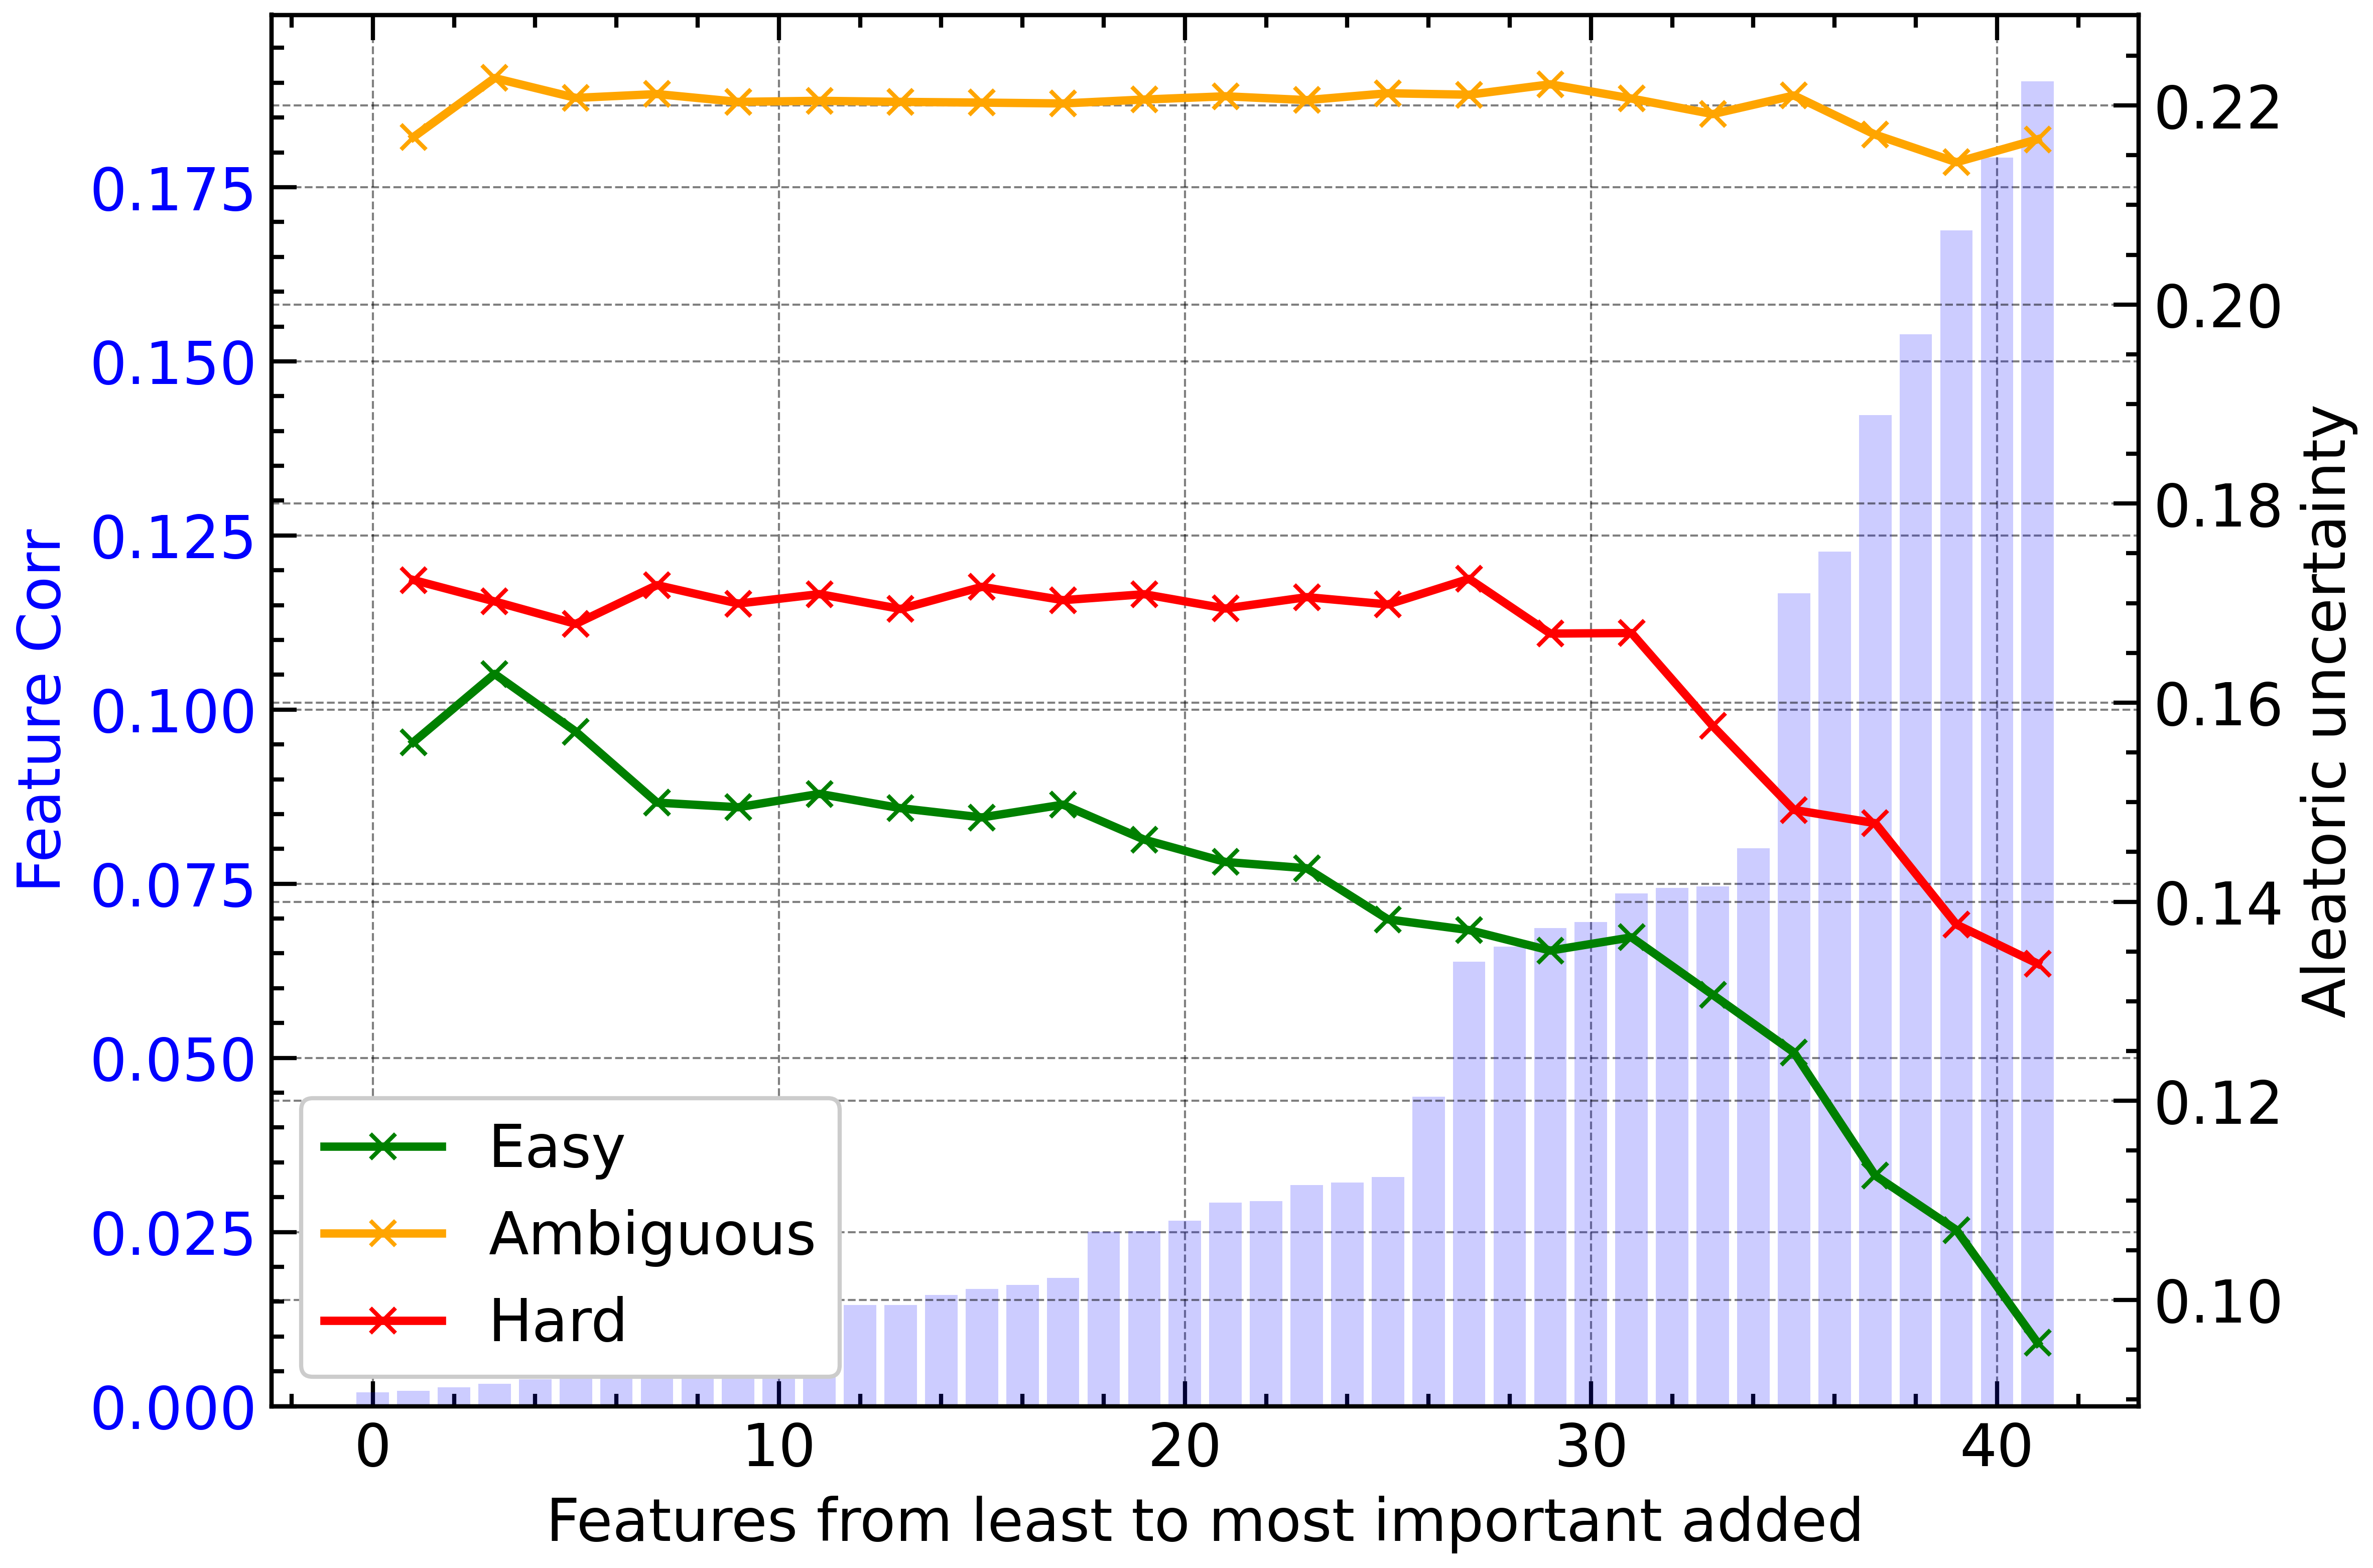

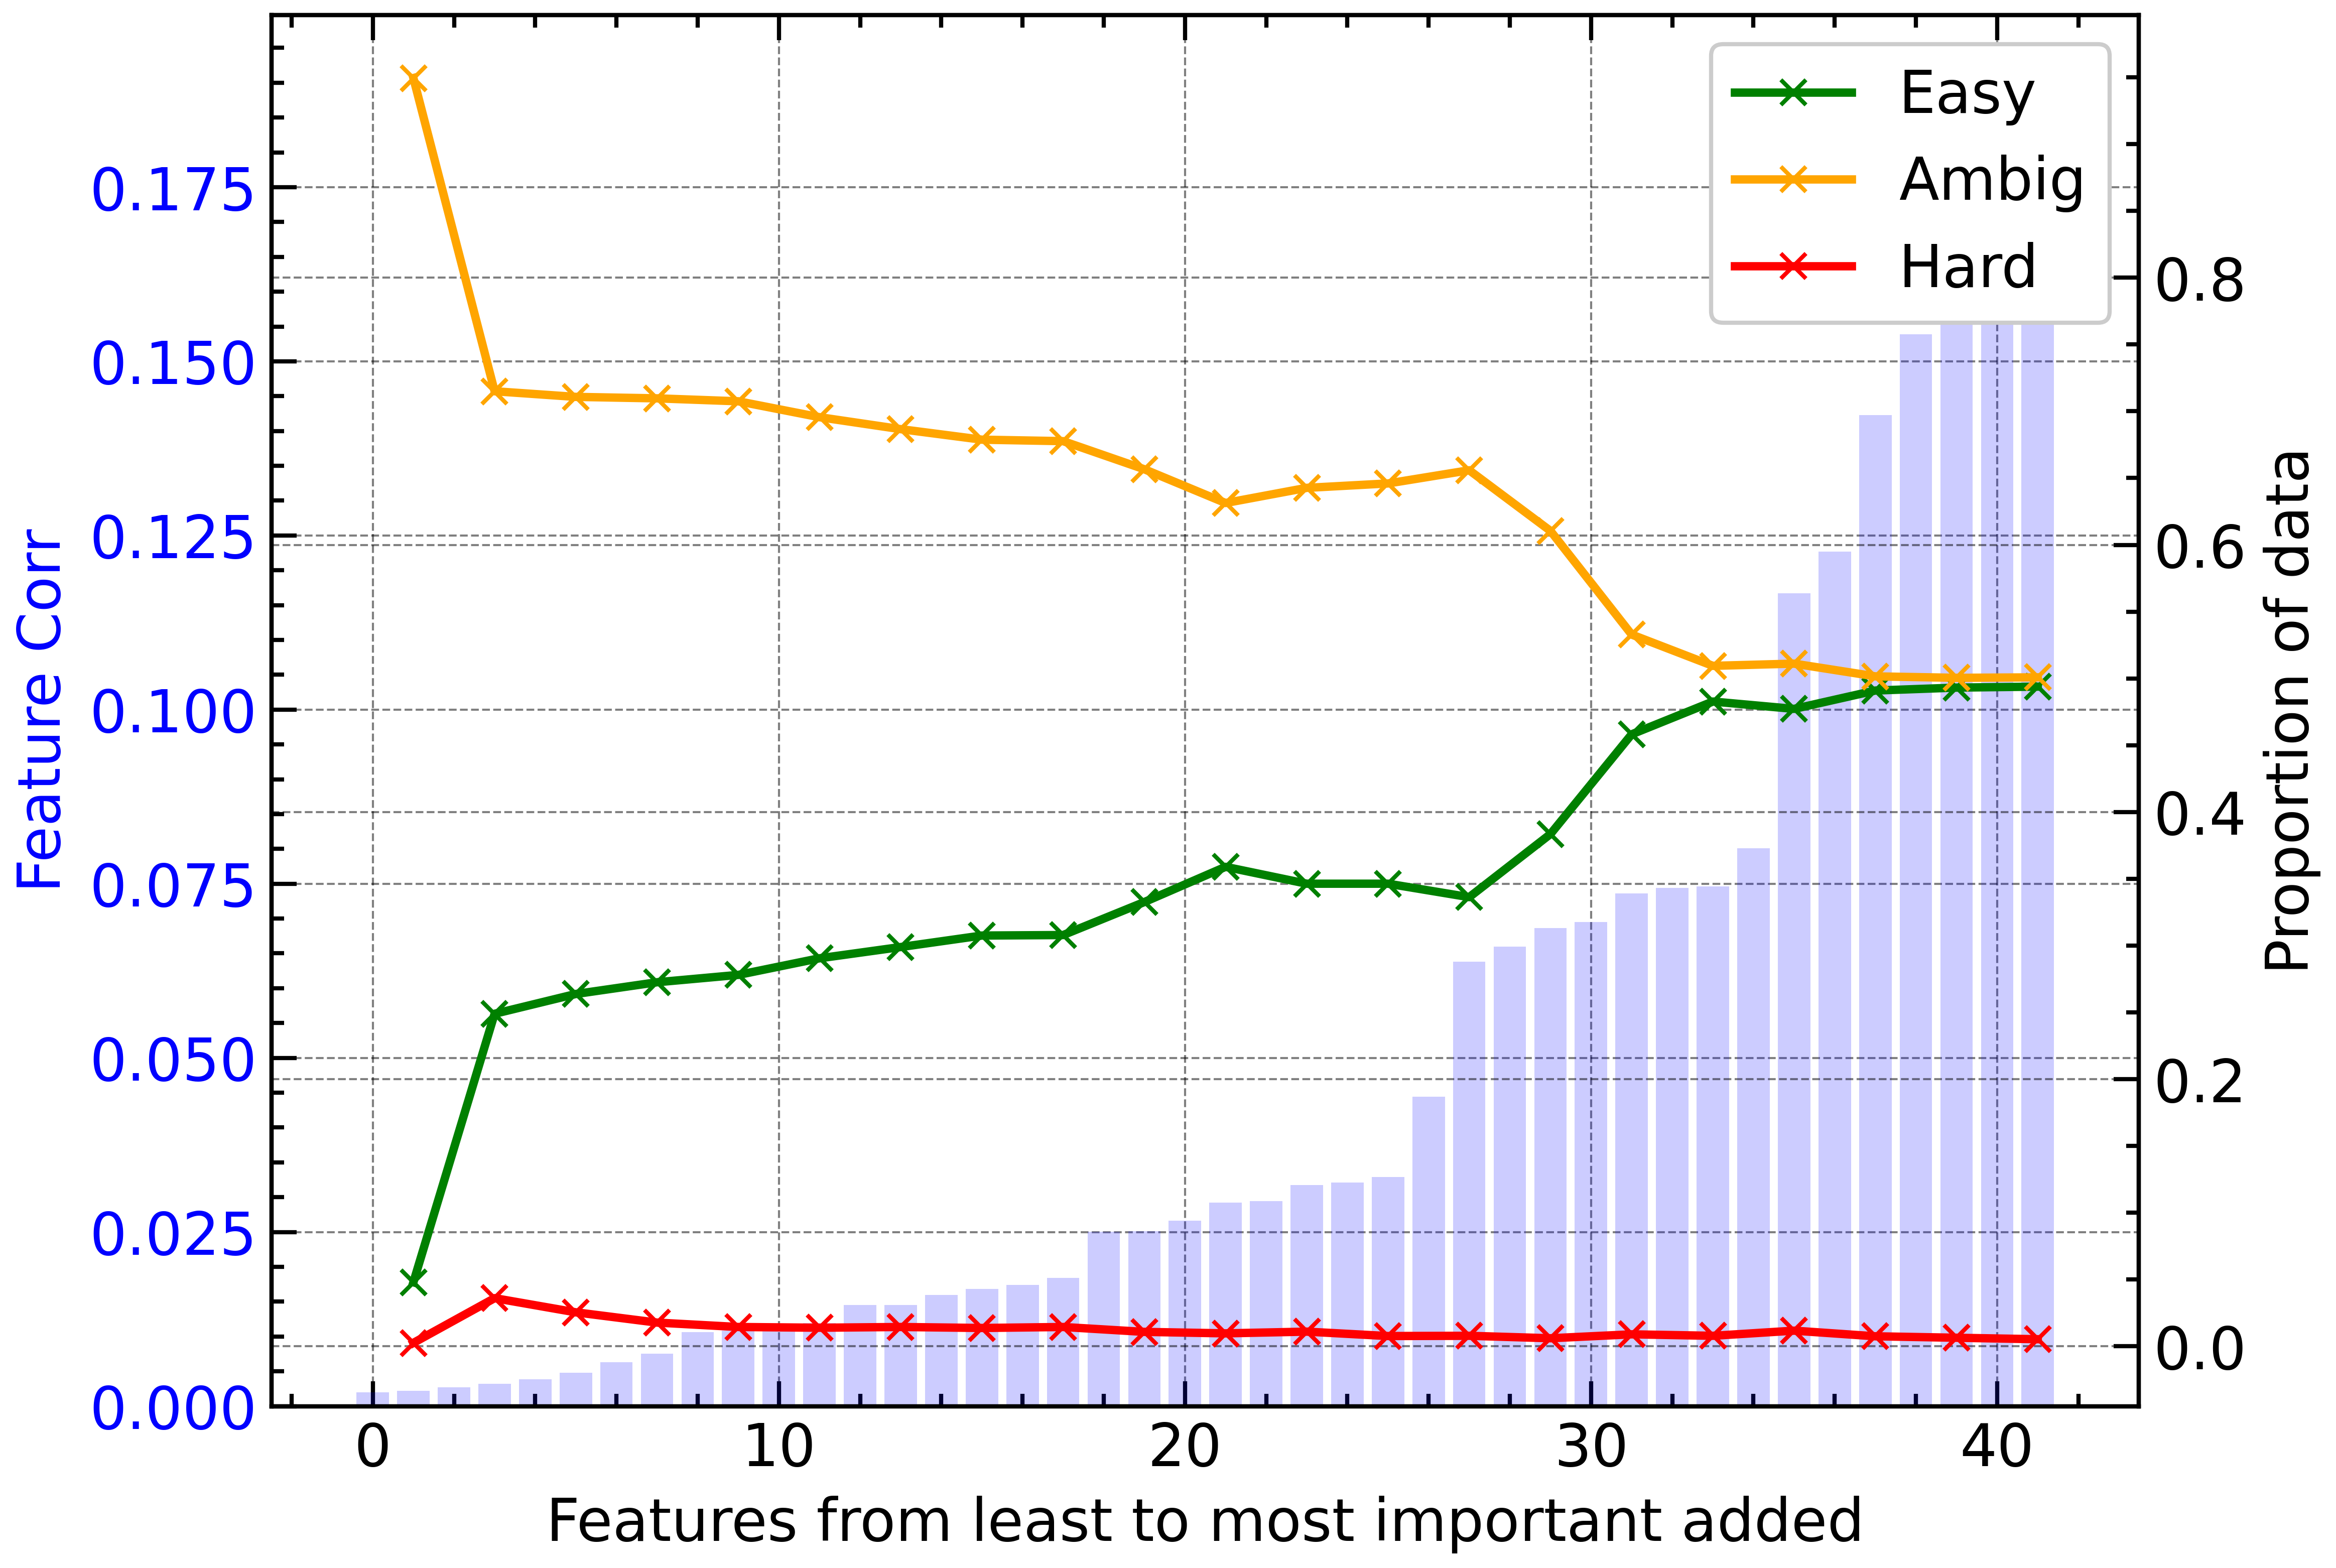

In [6]:
import matplotlib.pyplot as plt

plt.style.reload_library()
plt.style.use(["science", "ieee", "no-latex", "notebook", "grid", "vibrant"])
SMALL_SIZE = 10
MEDIUM_SIZE = 50
BIGGER_SIZE = 50

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=14)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=14)  # fontsize of the tick labels
plt.rc("ytick", labelsize=14)  # fontsize of the tick labels
plt.rc("legend", fontsize=14)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

if features:
    # Setup dummy data
    N = len(corr_vals)
    ind = np.arange(N)
    bars = np.random.randn(N)
    t = np.arange(0.01, 10.0, 0.01)

    # Plot graph with 2 y axes
    fig, ax1 = plt.subplots()
    # Plot bars
    ax1.bar(ind, corr_vals.values, alpha=0.2, color="b")
    ax1.set_xlabel("Features from least to most important added")

    # Make the y-axis label and tick labels match the line color.
    ax1.set_ylabel("Feature Corr", color="b")
    [tl.set_color("b") for tl in ax1.get_yticklabels()]

    # Set up ax2 to be the second y axis with x shared
    ax2 = ax1.twinx()

    if samples:
        scale = 10
    if features:
        scale = 1

    xaxis = list(range(1, len(n_easy) + 1, 2))
    xaxis = [scale * x for x in xaxis]

    ax2.plot(xaxis, easy_uncert[::2], marker="x", label="Easy", color="g")
    ax2.plot(xaxis, ambig_uncert[::2], marker="x", label="Ambiguous", color="orange")
    ax2.plot(xaxis, hard_uncert[::2], marker="x", label="Hard", color="r")

    if not dataiq:
        ax2.set_ylabel("Variability", color="k")
    else:
        ax2.set_ylabel("Aleatoric uncertainty", color="k")
    [tl.set_color("k") for tl in ax2.get_yticklabels()]

    plt.legend()
    #plt.savefig(f"{dataset}_feat_acquire_metric_{model_name}.pdf")
    plt.show()

    # Plot graph with 2 y axes
    fig, ax1 = plt.subplots()

    # Plot bars
    ax1.bar(ind, corr_vals, alpha=0.2, color="b")
    ax1.set_xlabel("Features from least to most important added")

    # Make the y-axis label and tick labels match the line color.
    ax1.set_ylabel("Feature Corr", color="b")
    [tl.set_color("b") for tl in ax1.get_yticklabels()]

    # Set up ax2 to be the second y axis with x shared
    ax2 = ax1.twinx()

    if samples:
        scale = 10
    if features:
        scale = 1

    xaxis = list(range(1, len(n_easy) + 1, 2))
    xaxis = [scale * x for x in xaxis]

    ax2.plot(xaxis, n_easy[::2], marker="x", label="Easy", color="g")
    ax2.plot(xaxis, n_ambig[::2], marker="x", label="Ambig", color="orange")
    ax2.plot(xaxis, n_hard[::2], marker="x", label="Hard", color="r")
    # Plot a line
    # ax2.plot(t, np.sin(0.25*np.pi*t), 'r-')

    # Make the y-axis label and tick labels match the line color.
    ax2.set_ylabel("Proportion of data", color="k")
    [tl.set_color("k") for tl in ax2.get_yticklabels()]
    plt.legend()
    #plt.savefig(f"{dataset}_feat_acquire_prop_{model_name}.pdf")
    plt.show()

if samples:
    plt.figure()
    plt.plot(
        [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        n_easy,
        marker="x",
        label="Easy",
        color="g",
    )
    plt.plot(
        [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        n_ambig,
        marker="x",
        label="Ambiguous",
        color="orange",
    )
    plt.plot(
        [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        n_hard,
        marker="x",
        label="Hard",
        color="r",
    )
    plt.xlabel("Percentage of data sampled (i.e. increase training size)")
    plt.ylabel("Proportion of dataset")
    plt.show()
